In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from dataclasses import dataclass, field
import utils
from tsfresh import extract_features
# from torch_geometric_temporal import  DynamicGraphTemporalSignal,StaticGraphTemporalSignal, temporal_signal_split, DynamicGraphTemporalSignalBatch
import networkx as nx
from torch_geometric.utils import from_networkx
import scipy
import sklearn
import random
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.ops import sigmoid_focal_loss

# from torch_geometric_temporal.nn.recurrent import DCRNN,  GConvGRU, A3TGCN, TGCN2, TGCN, A3TGCN2
# from torch_geometric_temporal.nn.attention import STConv
from torchmetrics.classification import BinaryRecall, BinarySpecificity, AUROC, ROC
from torch_geometric.nn import global_mean_pool
import pytorch_lightning as pl
from torch_geometric.nn import GCNConv, BatchNorm, GATv2Conv
from sklearn.model_selection import StratifiedShuffleSplit
from mne_features.univariate import (
    compute_variance,
    compute_hjorth_complexity,
    compute_hjorth_mobility,
    compute_line_length,
    compute_higuchi_fd,
    compute_katz_fd,
)
import mne_features
import torch_geometric
from imblearn.over_sampling import SMOTE
from collections import Counter
from librosa import zero_crossings
from scipy.signal import find_peaks, peak_prominences
from statistics import mean
from joblib import Parallel, delayed
import multiprocessing
import time

/home/szymon/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch_geometric.seed_everything(42)

In [3]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [4]:
# TODO think about using kwargs argument here to specify args for dataloader
@dataclass
class SeizureDataLoader:
    npy_dataset_path: Path
    event_tables_path: Path
    plv_values_path: Path
    loso_patient: str = None
    sampling_f: int = 256
    seizure_lookback: int = 600
    sample_timestep: int = 5
    inter_overlap: int = 0
    preictal_overlap: int = 0
    ictal_overlap: int = 0
    self_loops: bool = True
    balance: bool = True
    train_test_split: float = None
    fft: bool = False
    hjorth: bool = False
    downsample: int = None
    buffer_time: int = 15
    batch_size: int = 32
    smote: bool = False
    tsfresh: bool = False
    used_classes_dict: dict[str] = field(default_factory=lambda: {"interictal": True, "preictal": True, "ictal": True})
    """Class to prepare dataloaders for eeg seizure perdiction from stored files.

    Attributes:
        npy_dataset_path: (Path) Path to directory with .npy files
        event_tables_path: (Path) Path to directory with .csv files
        plv_values_path: (Path) Path to directory with .npy files
        loso_patient: (str) Patient name to be left out of training set.
    If None, no patient is left out for testing. (default: None)
        sampling_f: (int) Sampling frequency of the recordings. (default: 256)
        seizure_lookback: (int) Time in seconds to look back from seizure onset. (default: 600)
        sample_timestep: (int) Time in seconds between samples. (default: 5)
        inter_overlap: (int) Time in seconds to overlap between interictal samples. (default: 0)
        preictal_overlap: (int) Time in seconds to overlap between preictal samples. (default: 0)
        ictal_overlap: (int) Time in seconds to overlap between ictal samples. (default: 0)
        self_loops: (bool) Whether to add self loops to the graph. (default: True)
        balance: (bool) Whether to balance the classes. (default: True)
        train_test_split: (float) Percentage of data to be used for testing. (default: None)
        fft: (bool) Whether to use fft features. (default: False)
        hjorth: (bool) Whether to use hjorth features. (default: False)
        downsample: (int) Factor by which to downsample the data. (default: None)
        buffer_time: (int) Time in seconds to skip before and after every sample from seizure period. 
    (default: 15)
        batch_size: (int) Batch size for dataloaders. (default: 32)
        smote: (bool) Whether to use smote to balance the classes. (default: False)
        used_classes_ditct: (dict) Dictionary with classes to be used. 
    (default: {'interictal': True, 'preictal': True, 'ictal': True})

    
    """
    # if used_classes_dict is None:
    #     used_classes_dict = {"interictal": True, "preictal": True, "ictal": True}
    assert (fft and hjorth) == False, "When fft is True, hjorth should be False"
    assert (downsample is None) or (
        downsample > 0
    ), "Downsample should be None or positive integer"
    assert (train_test_split is None) or (
        train_test_split > 0 and train_test_split < 1
    ), "Train test split should be None or float between 0 and 1"
    
    assert not (smote and balance), "Cannot use smote and balance at the same time"
    assert not ((fft or hjorth) and tsfresh), "Cannot use fft or hjorth and tsfresh at the same time"

    def _get_event_tables(self, patient_name: str) -> tuple[dict, dict]:
        """Read events for given patient into start and stop times lists from .csv extracted files.
        Args:
            patient_name: (str) Name of the patient to get events for.
        Returns:
            start_events_dict: (dict) Dictionary with start events for given patient.
            stop_events_dict: (dict) Dictionary with stop events for given patient.
        """

        event_table_list = os.listdir(self.event_tables_path)
        patient_event_tables = [
            os.path.join(self.event_tables_path, ev_table)
            for ev_table in event_table_list
            if patient_name in ev_table
        ]
        patient_event_tables = sorted(patient_event_tables)
        patient_start_table = patient_event_tables[
            0
        ]  ## done terribly, but it has to be so for win/linux compat
        patient_stop_table = patient_event_tables[1]
        start_events_dict = pd.read_csv(patient_start_table).to_dict("index")
        stop_events_dict = pd.read_csv(patient_stop_table).to_dict("index")
        return start_events_dict, stop_events_dict

    def _get_recording_events(self, events_dict, recording) -> list[int]:
        """Read seizure times into list from event_dict.
        Args:
            events_dict: (dict) Dictionary with events for given patient.
            recording: (str) Name of the recording to get events for.
        Returns:
            recording_events: (list) List of seizure event start and stop time for given recording.
        """
        recording_list = list(events_dict[recording + ".edf"].values())
        recording_events = [int(x) for x in recording_list if not np.isnan(x)]
        return recording_events

    def _get_graph(self, n_nodes: int) -> nx.Graph:
        """Creates Networx complete graph with self loops
        for given number of nodes.
        Args:
            n_nodes: (int) Number of nodes in the graph.
        Returns:
            graph: (nx.Graph) Fully connected graph with self loops.
        """
        graph = nx.complete_graph(n_nodes)
        self_loops = [[node, node] for node in graph.nodes()]
        graph.add_edges_from(self_loops)
        return graph

    def _get_edge_weights_recording(self, plv_values: np.ndarray) -> np.ndarray:
        """Method for extracting PLV values associated with given edges for a recording.
        The PLV was computed for the entire recroding for all channels when the recording was
        processed.
        Args:
            plv_values: (np.ndarray) Array with PLV values for given recording.
        Returns:
            edge_weights: (np.ndarray) Array with PLV values for given edges.
        """
        graph = self._get_graph(plv_values.shape[0])
        garph_dict = {}
        for edge in graph.edges():
            e_start, e_end = edge
            garph_dict[edge] = {"plv": plv_values[e_start, e_end]}
        nx.set_edge_attributes(graph, garph_dict)
        edge_weights = from_networkx(graph).plv.numpy()
        return edge_weights

    def _get_edges(self):
        """Method to assign edge attributes. Has to be called AFTER get_dataset() method."""
        graph = self._get_graph(self._features.shape[1])
        edges = np.expand_dims(from_networkx(graph).edge_index.numpy(), axis=0)
        edges_per_sample_train = np.repeat(
            edges, repeats=self._features.shape[0], axis=0
        )
        self._edges = torch.tensor(edges_per_sample_train)
        if self.loso_patient is not None:
            edges_per_sample_val = np.repeat(
                edges, repeats=self._val_features.shape[0], axis=0
            )
            self._val_edges = torch.tensor(edges_per_sample_val)

    def _array_to_tensor(self):
        """Method converting features, edges and weights to torch.tensors"""

        self._features = torch.from_numpy(self._features)
        self._labels = torch.from_numpy(self._labels)
        # self._time_labels = torch.from_numpy(self._time_labels)
        # self._edge_weights = torch.from_numpy(self._edge_weights)
        if self.loso_patient is not None:
            self._val_features = torch.from_numpy(self._val_features)
            self._val_labels = torch.from_numpy(self._val_labels)
            # self._val_time_labels = torch.from_numpy(self._val_time_labels)
            # self._val_edge_weights = torch.from_numpy(self._val_edge_weights)

    def _get_labels_count(self):
        """Convenience method to get counts of labels in the dataset."""
        labels, counts = np.unique(self._labels, return_counts=True)
        self._label_counts = {}
        for n, label in enumerate(labels):
            self._label_counts[int(label)] = counts[n]
        if self.loso_patient is not None:
            labels, counts = np.unique(self._val_labels, return_counts=True)
            self._val_label_counts = {}
            for n, label in enumerate(labels):
                self._val_label_counts[int(label)] = counts[n]

    def _calculate_hjorth_features(self, features):
        """Converting features to Hjorth features.
        Args:
            features: (np.ndarray) Array with features to be converted.
        Returns:
            new_features: (np.ndarray) Array with Hjorth features.
        """
        new_features = np.array(
            [
                np.concatenate(
                    [
                        np.expand_dims(compute_variance(feature), 1),
                        np.expand_dims(compute_hjorth_mobility(feature), 1),
                        np.expand_dims(compute_hjorth_complexity(feature), 1),
                        np.expand_dims(compute_line_length(feature), 1),
                        # np.expand_dims(compute_katz_fd(feature), 1),
                    ],
                    axis=1,
                )
                for feature in features
            ]
        )
        return new_features

    def _features_to_data_list(self, features, edges, labels):
        """Converts features, edges and labels to list of torch_geometric.data.Data objects.
        Args:
            features: (np.ndarray) Array with features.
            edges: (np.ndarray) Array with edges.
            labels: (np.ndarray) Array with labels.
        Returns:
            data_list: (list) List of torch_geometric.data.Data objects.
        """
        data_list = [
            Data(
                x=features[i],
                edge_index=edges[i],
                # edge_attr=edge_weights[i],
                y=labels[i],
                # time=time_label[i],
            )
            for i in range(len(features))
        ]
        return data_list

    def _split_data_list(self, data_list):
        """Methods for splitting list of torch_geometric.data.Data objects into train and validation sets.
        Uses StratifiedShuffleSplit to ensure that the classes are balanced in both sets.
        Args:
            data_list: (list) List of torch_geometric.data.Data objects.
        Returns:
            data_list_train: (list) List of torch_geometric.data.Data objects for training.
            dataset_list_val: (list) List of torch_geometric.data.Data objects for validation.
        """
        class_labels = torch.tensor(
            [data.y.item() for data in data_list], dtype=torch.float32
        ).unsqueeze(1)
        patient_labels = torch.tensor(
            np.expand_dims(self._patient_number, 1), dtype=torch.float32
        )
        class_labels_patient_labels = torch.cat([class_labels, patient_labels], dim=1)
        splitter = StratifiedShuffleSplit(
            n_splits=1, test_size=self.train_test_split, random_state=42
        )
        train_indices, val_indices = next(
            splitter.split(data_list, class_labels_patient_labels)
        )
        self._indexes_to_later_delete = {"train": train_indices, "val": val_indices}
        data_list_train = [data_list[i] for i in train_indices]
        dataset_list_val = [data_list[i] for i in val_indices]
        return data_list_train, dataset_list_val

    def _initialize_dicts(self):
        """Temporary method to initialize dictionaries for storing features, labels, etc.
        Looks terrible, but convenient so far.
        """
        self._features_dict = {}
        self._labels_dict = {}
        self._time_labels_dict = {}
        self._edge_weights_dict = {}
        self._patient_number_dict = {}
        if self.loso_patient:
            self._val_features_dict = {}
            self._val_labels_dict = {}
            self._val_time_labels_dict = {}
            self._val_edge_weights_dict = {}
            self._val_patient_number_dict = {}

    def _convert_dict_to_array(self):
        """A method to convert dictionaries to numpy arrays. This approach with dicts is redundant,
        but allows for joblib parallelization for data loading by not using concatenation in the loading loop.
        """
        self._features = np.concatenate(
            [self._features_dict[key] for key in self._features_dict.keys()]
        )
        del self._features_dict
        self._labels = np.concatenate(
            [self._labels_dict[key] for key in self._labels_dict.keys()]
        )
        del self._labels_dict
        # self._time_labels = np.concatenate(
        #     [self._time_labels_dict[key] for key in self._time_labels_dict.keys()]
        # )
        # del self._time_labels_dict
        # self._edge_weights = np.concatenate(
        #     [self._edge_weights_dict[key] for key in self._edge_weights_dict.keys()]
        # )
        # del self._edge_weights_dict
        self._patient_number = np.concatenate(
            [self._patient_number_dict[key] for key in self._patient_number_dict.keys()]
        )
        del self._patient_number_dict
        if self.loso_patient:
            self._val_features = np.concatenate(
                [self._val_features_dict[key] for key in self._val_features_dict.keys()]
            )
            del self._val_features_dict
            self._val_labels = np.concatenate(
                [self._val_labels_dict[key] for key in self._val_labels_dict.keys()]
            )
            del self._val_labels_dict
            # self._val_time_labels = np.concatenate(
            #     [
            #         self._val_time_labels_dict[key]
            #         for key in self._val_time_labels_dict.keys()
            #     ]
            # )
            # del self._val_time_labels_dict
            # self._val_edge_weights = np.concatenate(
            #     [
            #         self._val_edge_weights_dict[key]
            #         for key in self._val_edge_weights_dict.keys()
            #     ]
            # )
            # del self._val_edge_weights_dict
            self._val_patient_number = np.concatenate(
                [
                    self._val_patient_number_dict[key]
                    for key in self._val_patient_number_dict.keys()
                ]
            )
            del self._val_patient_number_dict

    def _balance_classes(self):
        """Method to balance classes in the dataset by removing samples from the majority class.
        Currently works only for interictal and ictal classes."""
        negative_label = self._label_counts[0]
        positive_label = self._label_counts[1]

        print(f"Number of negative samples pre removal {negative_label}")
        print(f"Number of positive samples pre removal {positive_label}")
        imbalance = negative_label - positive_label
        print(f"imbalance {imbalance}")
        negative_indices = np.where(self._labels == 0)[0]
        indices_to_discard = np.random.choice(
            negative_indices, size=imbalance, replace=False
        )

        self._features = np.delete(self._features, obj=indices_to_discard, axis=0)
        self._labels = np.delete(self._labels, obj=indices_to_discard, axis=0)
        self._time_labels = np.delete(self._time_labels, obj=indices_to_discard, axis=0)
        self._edge_weights = np.delete(
            self._edge_weights, obj=indices_to_discard, axis=0
        )
        self._patient_number = np.delete(
            self._patient_number, obj=indices_to_discard, axis=0
        )

    def _standardize_data(self, features, labels, loso_features=None):
        """Standardize features by subtracting mean and dividing by standard deviation.
        The mean and std are computed from the interictal class. The same values are used for loso_features.
        Args:
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
            loso_features (optional): (np.ndarray) Array with features for LOSO patient.
        """
        indexes = np.where(labels == 0)[0]
        features_negative = features[indexes]
        channel_mean = features_negative.mean()
        channel_std = features_negative.std()

        for i in range(features.shape[0]):
            for n in range(features.shape[1]):
                features[i, n, :] = (features[i, n, :] - channel_mean) / channel_std
        if (
            loso_features is not None
        ):  ## standardize loso features with the same values as for training data
            
            for i in range(loso_features.shape[0]):
                for n in range(loso_features.shape[1]):
                    loso_features[i, n, :] = (
                        loso_features[i, n, :] - channel_mean
                    ) / channel_std

    def _min_max_scale(self, features, labels, loso_features=None):
        """Min max scale features to range [0,1]. The min and max values are computed from the interictal class.
        Args:
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
        """
        indexes = np.where(labels == 0)[0]
        features_negative = features[indexes]

        channel_min = features_negative.min()
        channel_max = features_negative.max()
        for i in range(features.shape[0]):
            for n in range(features.shape[1]):
                features[i, n, :] = (features[i, n, :] - channel_min) / (
                    channel_max - channel_min
                )
        if loso_features is not None:
            for i in range(loso_features.shape[0]):
                for n in range(loso_features.shape[1]):
                    loso_features[i, n, :] = (loso_features[i, n, :] - channel_min) / (
                        channel_max - channel_min
                    )

    def _apply_smote(self, features, labels):
        """Performs SMOTE oversampling on the dataset. Implemented for preictal vs ictal scenarion only.
        Args:
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
        Returns:
            x_train_smote: (np.ndarray) Array with SMOTE oversampled features.
            y_train_smote: (np.ndarray) Array with SMOTE oversampled labels.
        """
        dim_1, dim_2, dim_3 = features.shape

        new_dim = dim_1 * dim_2
        new_x_train = features.reshape(new_dim, dim_3)
        new_y_train = []
        for i in range(len(labels)):
            new_y_train.extend([labels[i]] * dim_2)

        new_y_train = np.array(new_y_train)

        # transform the dataset
        oversample = SMOTE(random_state=42)
        x_train, y_train = oversample.fit_resample(new_x_train, new_y_train)
        x_train_smote = x_train.reshape(int(x_train.shape[0] / dim_2), dim_2, dim_3)
        y_train_smote = []
        for i in range(int(x_train.shape[0] / dim_2)):
            # print(i)
            value_list = list(y_train.reshape(int(x_train.shape[0] / dim_2), dim_2)[i])
            # print(list(set(value_list)))
            y_train_smote.extend(list(set(value_list)))
            ## Check: if there is any different value in a list
            if len(set(value_list)) != 1:
                print(
                    "\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n"
                )
        y_train_smote = np.array(y_train_smote)
        # print(np.unique(y_train_smote,return_counts=True))
        return x_train_smote, y_train_smote

    def _compute_tsfresh_features(self, features):
        """Compute tsfresh features for given features. The features are computed for each channel in every sample.
        Currently the extracted features are hardcoded into the method.
        Args:
            features: (np.ndarray) Array with features.
        Returns:
            new_features: (np.ndarray) Array with tsfresh features.
        """
        fc_parameters = {
            "abs_energy" : None,
            "absolute_sum_of_changes" : None,
            "agg_autocorrelation" : [{"f_agg": "mean", "maxlag": 10}],
            "autocorrelation" : [{"lag": 10}],
            "number_peaks" : [{"n":5}],
            "c3" : [{"lag": 10}],
            "cid_ce" : [{"normalize": True}],
            "longest_strike_below_mean" : None,
            "longest_strike_above_mean" : None,
            "fourier_entropy" : [{"bins": 10}],
            "mean_change" : None,
            "number_crossing_m" : [{"m": 0}],
            "sample_entropy" : None,
            "variance" : None,
            "variation_coefficient" : None,
        }
        n_variables = len(fc_parameters.keys())
        n_nodes = features[0].shape[0]
        for n,case in enumerate(features):
            new_dataframe = pd.DataFrame(columns=['id','time','channel','value'])
            new_dataframe["id"] = np.repeat(n,case.shape[0]*case.shape[1])
            new_dataframe["time"] = np.tile(np.arange(case.shape[1]),case.shape[0])
            new_dataframe["channel"] = np.stack([torch.full([case.shape[1]],i) for i in range(case.shape[0])]).flatten()
            new_dataframe['value'] = abs(case.flatten())
            extracted_features = extract_features(
            new_dataframe,
            column_id="id",
            column_sort="time",
            column_kind="channel",
            column_value="value",
            default_fc_parameters=fc_parameters,
            n_jobs=6
            )

            try:
                final_df = pd.concat([final_df,extracted_features],axis=0)
            except:
                final_df = extracted_features
        new_features = final_df.to_numpy().reshape(-1,n_nodes,n_variables)
        return new_features
    def _extend_data(
        self,
        patient,
        patient_number,
        features,
        labels,
        time_labels=None,
        plv_edge_weights=None,
    ):
        """Convenience method to extend the dictionaries with features, labels, time labels and edge weights.
        Args:
            patient: (str) Name of the patient to extend the dictionaries for.
            patient_number: (int) Patient number to extend the dictionaries for.
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
            time_labels (optional): (np.ndarray) Array with time labels.
            plv_edge_weights (optional): (np.ndarray) Array with edge weights.
        """
        if patient == self.loso_patient:
            # logging.info(f"Adding recording {record} of patient {patient}")
            try:
                self._val_features_dict[patient] = np.concatenate(
                    (self._val_features_dict[patient], features), axis=0
                )
                self._val_labels_dict[patient] = np.concatenate(
                    (self._val_labels_dict[patient], labels), axis=0
                )
                # self._val_time_labels_dict[patient] = np.concatenate(
                #     (self._val_time_labels_dict[patient], time_labels), axis=0
                # )
                # self._val_edge_weights_dict[patient] = np.concatenate(
                #     (
                #         self._val_edge_weights_dict[patient],
                #         np.repeat(plv_edge_weights, features.shape[0], axis=0),
                #     )
                # )

                self._val_patient_number_dict[patient] = np.concatenate(
                    (self._val_patient_number_dict[patient], patient_number)
                )
            except:
                self._val_features_dict[patient] = features
                self._val_labels_dict[patient] = labels
                # self._val_time_labels_dict[patient] = time_labels
                # self._val_edge_weights_dict[patient] = np.repeat(
                #     plv_edge_weights, features.shape[0], axis=0
                # )
                self._val_patient_number_dict[patient] = patient_number

        else:
            try:
                self._features_dict[patient] = np.concatenate(
                    (self._features_dict[patient], features), axis=0
                )
                self._labels_dict[patient] = np.concatenate(
                    (self._labels_dict[patient], labels), axis=0
                )
                # self._time_labels_dict[patient] = np.concatenate(
                #     (self._time_labels_dict[patient], time_labels), axis=0
                # )
                # self._edge_weights_dict[patient] = np.concatenate(
                #     (
                #         self._edge_weights_dict[patient],
                #         np.repeat(plv_edge_weights, features.shape[0], axis=0),
                #     )
                # )

                self._patient_number_dict[patient] = np.concatenate(
                    (self._patient_number_dict[patient], patient_number)
                )
            except:
                self._features_dict[patient] = features
                self._labels_dict[patient] = labels
                # self._time_labels_dict[patient] = time_labels
                # self._edge_weights_dict[patient] = np.repeat(
                #     plv_edge_weights, features.shape[0], axis=0
                # )
                self._patient_number_dict[patient] = patient_number

    def _get_labels_features_edge_weights_seizure(self, patient):
        """Method to extract features, labels and edge weights for seizure and interictal samples."""

        event_tables = self._get_event_tables(
            patient
        )  # extract start and stop of seizure for patient
        patient_path = os.path.join(self.npy_dataset_path, patient)
        recording_list = [
            recording
            for recording in os.listdir(patient_path)
            if "seizures" in recording
        ]
        for record in recording_list:  # iterate over recordings for a patient
            recording_path = os.path.join(patient_path, record)
            record = record.replace(
                "seizures_", ""
            )  ## some magic to get it properly working with event tables
            record_id = record.split(".npy")[0]  #  get record id
            start_event_tables = self._get_recording_events(
                event_tables[0], record_id
            )  # get start events
            stop_event_tables = self._get_recording_events(
                event_tables[1], record_id
            )  # get stop events
            data_array = np.load(recording_path)  # load the recording

            # plv_edge_weights = np.expand_dims(
            #     self._get_edge_weights_recording(
            #         np.load(os.path.join(self.plv_values_path, patient, record))
            #     ),
            #     axis=0,
            # )

            features, labels, time_labels = utils.extract_training_data_and_labels(
                data_array,
                start_event_tables,
                stop_event_tables,
                fs=self.sampling_f,
                seizure_lookback=self.seizure_lookback,
                sample_timestep=self.sample_timestep,
                preictal_overlap=self.preictal_overlap,
                ictal_overlap=self.ictal_overlap,
                buffer_time=self.buffer_time,
            )

            if features is None:
                print(
                    f"Skipping the recording {record} patients {patient} cuz features are none"
                )
                continue
            # if len(np.unique(labels)) != 2:
            #     print(
            #         f"Skipping the recording {record} patients {patient} cuz no seizure samples"
            #     )
            #     continue

            features = features.squeeze(2)

            if self.downsample:
                new_sample_count = int(self.downsample * self.sample_timestep)
                features = scipy.signal.resample(features, new_sample_count, axis=2)
            if self.fft:
                features = np.fft.rfft(features, axis=2)
            if self.smote:
                features, labels = self._apply_smote(features, labels)
            time_labels = np.expand_dims(time_labels.astype(np.int32), 1)
            labels = labels.reshape((labels.shape[0], 1)).astype(np.float32)
            patient_number = torch.full(
                [labels.shape[0]],
                int("".join(x for x in patient if x.isdigit())),
                dtype=torch.float32,
            )

            self._extend_data(patient, patient_number, features, labels)

    def _get_labels_features_edge_weights_interictal(
        self, patient, samples_patient: int = None
    ):
        """Method to extract features, labels and edge weights for interictal samples.
        Args:
            patient: (str) Name of the patient to extract the data for.
            samples_patient (optional): (int) Number of samples to extract for a patient.
        Samples are extracted from non-seizure recordings for a patient, starting from random time point.
        If not specified, the number of samples is calculated as the number of interictal samples for a patient
        divided by the number of recordings for a patient.

        """
        patient_path = os.path.join(self.npy_dataset_path, patient)
        ## get all non-seizure recordings for a patient
        recording_list = [
            recording
            for recording in os.listdir(patient_path)
            if not "seizures_" in recording
        ]
        if samples_patient is None:
            patient_num = int("".join(filter(str.isdigit, patient)))
            if patient == self.loso_patient:
                patient_negatives = np.unique(
                    self._val_labels_dict[patient], return_counts=True
                )[1][0]
                samples_per_recording = int(patient_negatives / len(recording_list))
            else:
                patient_negatives = np.unique(
                    self._labels_dict[patient], return_counts=True
                )[1][0]
                samples_per_recording = int(patient_negatives / len(recording_list))
        else:
            samples_per_recording = int(samples_patient / len(recording_list))
        for recording in recording_list:
            recording_path = os.path.join(patient_path, recording)
            data_array = np.expand_dims(np.load(recording_path), 1)
            try:
                features, labels = utils.extract_training_data_and_labels_interictal(
                    input_array=data_array,
                    samples_per_recording=samples_per_recording,
                    fs=self.sampling_f,
                    timestep=self.sample_timestep,
                    overlap=self.preictal_overlap,
                )
            except:
                print(f"Skipping recording {recording} for patient due to the error")
                continue

            patient_number = torch.full(
                [labels.shape[0]],
                patient_num,
                dtype=torch.float32,
            )
            features = features.squeeze(2)
            if self.downsample:
                new_sample_count = int(self.downsample * self.sample_timestep)
                features = scipy.signal.resample(features, new_sample_count, axis=2)
            if self.fft:
                features = np.fft.rfft(features, axis=2)
            labels = labels.reshape((labels.shape[0], 1)).astype(np.float32)
            self._extend_data(patient, patient_number, features, labels)

    def _update_classes(self):
        """Method to remove samples of period that we do not want to load, as specified in used_classes_dict.
        If it is possible, the method aims set the interictal period as class 0 to be used for extracting normalization parameters.
        If it is not possible, preictal period remains chosen as class 0.
        """
        if (
            not self.used_classes_dict["ictal"]
            or not self.used_classes_dict["preictal"]
        ):
            label_to_delete = 0 if self.used_classes_dict["ictal"] else 1
            idx_to_delete = np.where(self._labels == label_to_delete)[0]
            self._features = np.delete(self._features, obj=idx_to_delete, axis=0)
            self._labels = np.delete(self._labels, obj=idx_to_delete, axis=0)
            self._patient_number = np.delete(
                self._patient_number, obj=idx_to_delete, axis=0
            )
            ## change labels of remaining classes
            if label_to_delete == 0:
                self._labels[self._labels == 2] = 0
                print(
                    "Deleted preictal samples, changed interictal label to 0,  ictal remains 1 "
                )
            else:
                self._labels[self._labels == 0] = 1
                self._labels[self._labels == 2] = 0
                print(
                    "Deleted ictal samples, changed interictal label to 0, preictal to 1"
                )
            if self.loso_patient is not None:
                idx_to_delete = np.where(self._val_labels == label_to_delete)[0]
                self._val_features = np.delete(
                    self._val_features, obj=idx_to_delete, axis=0
                )
                self._val_labels = np.delete(
                    self._val_labels, obj=idx_to_delete, axis=0
                )
                self._val_patient_number = np.delete(
                    self._val_patient_number, obj=idx_to_delete, axis=0
                )
                if label_to_delete == 0:
                    self._val_labels[self._val_labels == 2] = 0
                    print(
                        "Deleted preictal samples from LOSO patient, changed interictal label to 0, ictal remains 1 "
                    )
                else:
                    self._val_labels[self._val_labels == 0] = 1
                    self._val_labels[self._val_labels == 2] = 0
                    print(
                        "Deleted ictal from LOSO patient, changed interictal label to 0, preictal to 1"
                    )
        elif (sum(self.used_classes_dict.values())== 3): ## case when all three classes are used - just flipping labels
            self._labels[self._labels == 2] = 4 ## change interictal to 4 from 2 temporarily
            self._labels[self._labels == 0] = 2 ## change preictal to 2 from 0
            self._labels[self._labels == 4] = 0  ## change interictal to 0 from 4
            if self.loso_patient is not None:
                self._val_labels[self._val_labels == 2] = 4
                self._val_labels[self._val_labels == 0] = 2
                self._val_labels[self._val_labels == 4] = 0
    
    # TODO define a method to create edges and calculate plv to get weights
    def get_dataset(self):
        """Creating graph data iterators. The iterator yelds dynamic, weighted and undirected graphs
        containing self loops. Every node represents one electrode in EEG. The graph is fully connected,
        edge weights are calculated for every EEG recording as PLV between channels (edge weight describes
        the "strength" of connectivity between two channels in a recording). Node features are values of
        channel voltages in time. Features are of shape [nodes,features,timesteps].

        Returns:
            train_dataset {DynamicGraphTemporalSignal} -- Training data iterator.
            valid_dataset {DynamicGraphTemporalSignal} -- Validation data iterator (only if loso_patient is
            specified in class constructor).
        """
        ### TODO rozkminić o co chodzi z tym całym time labels - na razie wartość liczbowa która tam wchodzi
        ### to shape atrybutu time_labels
        assert (
            "interictal" in self.used_classes_dict.keys()
        ), "Please define the behavior for interictal class in used_classes_dict"
        assert (
            "preictal" in self.used_classes_dict.keys()
        ), "Please define the behavior for preictal class in used_classes_dict"
        assert (
            "ictal" in self.used_classes_dict.keys()
        ), "Please define the behavior for ictal class in used_classes_dict"
        
        assert (
            sum(self.used_classes_dict.values()) > 1
        ), "Please define at least two classes to use in used_classes_dict"
        
        self._initialize_dicts()
        patient_list = os.listdir(self.npy_dataset_path)
        start_time = time.time()
        if self.smote:
            for patient in patient_list:
                self._get_labels_features_edge_weights_seizure(patient)
        else:
            Parallel(n_jobs=6, require="sharedmem")(
                delayed(self._get_labels_features_edge_weights_seizure)(patient)
                for patient in patient_list
            )
        print(
            f"Finished reading in {time.time() - start_time} seconds for seizure data"
        )
        if self.used_classes_dict["interictal"]:
            Parallel(n_jobs=6, require="sharedmem")(
                delayed(self._get_labels_features_edge_weights_interictal)(patient)
                for patient in patient_list
            )

        self._convert_dict_to_array()
        self._update_classes()

        self._get_labels_count()
        if self.tsfresh:
            self._features = self._compute_tsfresh_features(self._features)
            if self.loso_patient is not None:
                self._val_features = self._compute_tsfresh_features(self._val_features)
        if self.balance:
            self._balance_classes()

        print(
            f"Finished reading in {time.time() - start_time} seconds for non seizure data"
        )
        start_time_preprocessing = time.time()
        self._standardize_data(self._features, self._labels, self._val_features)

        self._get_edges()
        # self._get_labels_count()
        if self.hjorth:
            self._features = self._calculate_hjorth_features(self._features)
            if self.loso_patient is not None:
                self._val_features = self._calculate_hjorth_features(self._val_features)
        self._array_to_tensor()

        if self.train_test_split is not None:
            if self.fft or self.hjorth:
                data_list = self._features_to_data_list(
                    self._features,
                    self._edges,
                    # self._edge_weights,
                    self._labels,
                    # self._time_labels,
                )
                train_data_list, val_data_list = self._split_data_list(data_list)
                label_count = np.unique(
                    [data.y.item() for data in train_data_list], return_counts=True
                )[1]
                self.alpha = label_count[0] / label_count[1]
                loaders = [
                    DataLoader(
                        train_data_list,
                        batch_size=self.batch_size,
                        shuffle=True,
                        drop_last=False,
                    ),
                    DataLoader(
                        val_data_list,
                        batch_size=len(val_data_list),
                        shuffle=False,
                        drop_last=False,
                    ),
                ]

            else:
                train_dataset = torch.utils.data.TensorDataset(
                    self._features,
                    self._edges,
                    # self._edge_weights,
                    self._labels,
                    # self._time_labels,
                )

                train_dataset, val_dataset = torch.utils.data.random_split(
                    train_dataset,
                    [1 - self.train_test_split, self.train_test_split],
                    generator=torch.Generator().manual_seed(42),
                )

                train_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=self.batch_size,
                    shuffle=True,
                    # num_workers=2,
                    # pin_memory=True,
                    # prefetch_factor=4,
                    drop_last=False,
                )

                val_dataloader = torch.utils.data.DataLoader(
                    val_dataset,
                    batch_size=self.batch_size,
                    shuffle=False,
                    # num_workers=2,
                    # pin_memory=True,
                    # prefetch_factor=4,
                    drop_last=False,
                )
                loaders = [train_dataloader, val_dataloader]
        else:
            if self.fft or self.hjorth:
                train_data_list = self._features_to_data_list(
                    self._features,
                    self._edges,
                    # self._edge_weights,
                    self._labels,
                    # self._time_labels,
                )
                loaders = [
                    DataLoader(
                        train_data_list,
                        batch_size=self.batch_size,
                        shuffle=True,
                        drop_last=False,
                    )
                ]
            else:
                train_dataset = torch.utils.data.TensorDataset(
                    self._features,
                    self._edges,
                    # self._edge_weights,
                    self._labels,
                    # self._time_labels,
                )
                train_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=self.batch_size,
                    shuffle=True,
                    # num_workers=2,
                    # pin_memory=True,
                    # prefetch_factor=4,
                    drop_last=False,
                )
                loaders = [train_dataloader]
        if self.loso_patient:
            # if self.hjorth:
            #     self._val_features = self._calculate_hjorth_features(self._val_features)

            if self.fft or self.hjorth:
                loso_data_list = self._features_to_data_list(
                    self._val_features,
                    self._val_edges,
                    # self._val_edge_weights,
                    self._val_labels,
                    # self._val_time_labels,
                )
                print("Preprocessing time: ", time.time() - start_time_preprocessing)
                return (
                    *loaders,
                    DataLoader(
                        loso_data_list,
                        batch_size=len(loso_data_list),
                        shuffle=False,
                        drop_last=False,
                    ),
                )
            loso_dataset = torch.utils.data.TensorDataset(
                self._val_features,
                self._val_edges,
                # self._val_edge_weights,
                self._val_labels,
                #  self._val_time_labels,
            )
            loso_dataloader = torch.utils.data.DataLoader(
                loso_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                # pin_memory=True,
                # num_workers=2,
                # prefetch_factor=4,
                drop_last=False,
            )

            return (*loaders, loso_dataloader)

        return (*loaders,)

    
            

In [ ]:
## TODO ekstrachować do osobnego loadera, oddzielić już ten jeden track całkowicie
## czy nie zapisać tego po prostu jako jeden duży HDF5, a potem wczytywać?
## pomyśleć o strukturze hdfa

In [5]:
TIMESTEP = 6
PREICTAL_OVERLAP = 0
ICTAL_OVERLAP = 0
INTER_OVERLAP = 0
SFREQ = 256
torch_geometric.seed_everything(42)
dataloader = SeizureDataLoader(
    npy_dataset_path=Path('data/npy_data_full'),
    event_tables_path=Path('data/event_tables'),
    plv_values_path=Path('data/plv_arrays'),
    loso_patient='chb20',
    sampling_f=SFREQ,
    seizure_lookback=600,
    sample_timestep= TIMESTEP,
    inter_overlap=INTER_OVERLAP,
    preictal_overlap=PREICTAL_OVERLAP,
    ictal_overlap=ICTAL_OVERLAP,
    self_loops=False,
    balance=False,
    train_test_split=0.05,
    fft=False,
    hjorth=False,
    downsample=60,
    batch_size=64,
    buffer_time=60,
    smote=False,
    tsfresh=False,
    used_classes_dict={"ictal": True, "interictal": True, "preictal": True}
    )
train_loader,valid_loader, loso_loader =dataloader.get_dataset() 
alpha = list(dataloader._label_counts.values())[0]/list(dataloader._label_counts.values())[1]
alpha

Skipping the recording chb20_12.npy patients chb20 cuz features are none
Finished reading in 12.127455711364746 seconds for seizure data
Skipping recording chb24_22.npy for patient due to the error


Feature Extraction: 100%|██████████| 18/18 [00:00<00:00, 105.68it/s]


KeyboardInterrupt: 

In [226]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def scale(x):
    return scaler.fit_transform(x)
vectorized_scaler = np.vectorize(scale)

In [229]:
new_features.shape

(3, 18, 15)

In [227]:
vectorized_scaler(new_features)


ValueError: Expected 2D array, got scalar array instead:
array=22.085349144793614.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [186]:
features_extracted_preictal = final_df.values[0].reshape(18,15)
features_extracted_ictal = final_df.values[1].reshape(18,15)
features_extracted_interictal = final_df.values[2].reshape(18,15)
features_extracted_preictal = scaler.fit_transform(features_extracted_preictal)
features_extracted_ictal = scaler.fit_transform(features_extracted_ictal)
features_extracted_interictal = scaler.fit_transform(features_extracted_interictal)

ValueError: x and y must be the same size

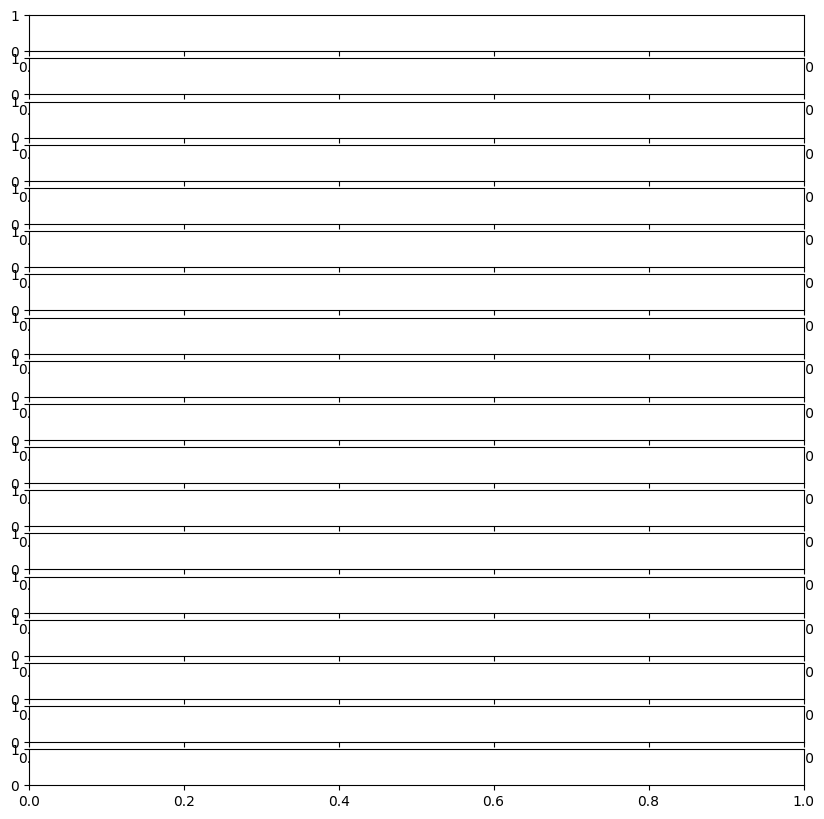

In [190]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(18,1,figsize=(10,10))

for i in range(18):
    ax[i].scatter(i,features_extracted_preictal[i])
    ax[i].scatter(i,features_extracted_ictal[i])
    ax[i].scatter(i,features_extracted_interictal[i])
    ax[i].set_title(f'Channel {i+1}')
plt.legend(['preictal', 'ictal', 'interictal'])
plt.show()

In [ ]:
extracted_features = extract_features(
    new_dataframe,
    column_id="id",
    column_sort="time",
    column_kind="channel",
    column_value="value",
    default_fc_parameters=fc_parameters,
)

In [ ]:
nl = np.stack(
    [
        new_dataframe[new_dataframe["channel"] == ch]["value"].to_list()
        for ch in new_dataframe["channel"].unique()
    ]
)

In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, timestep,sfreq, n_nodes=18,batch_size=32):
        super(RecurrentGCN, self).__init__()
        self.n_nodes = n_nodes
        self.out_features = 128
        self.recurrent_1 = A3TGCN2(sfreq*timestep,32, add_self_loops=True,improved=False)
        self.recurrent_2 = GCNConv(32,64,add_self_loops=True,improved=False)
        self.recurrent_3 = GCNConv(64,128,add_self_loops=True,improved=False)
        self.fc1 = torch.nn.Linear(n_nodes*128, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 1)
        self.flatten = torch.nn.Flatten(start_dim=0)
        self.dropout = torch.nn.Dropout()
    def forward(self, x, edge_index,edge_weight,batch):
        x = torch.squeeze(x)
        h = self.recurrent_1(x, edge_index=edge_index, edge_weight = edge_weight)
        h = torch.nn.BatchNorm1d(32)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_2(h, edge_index,edge_weight)
        h = torch.nn.BatchNorm1d(64)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_3(h, edge_index,edge_weight)
        h = torch.nn.BatchNorm1d(128)(h)
        h = F.leaky_relu(h)
        h = global_mean_pool(h,batch)
        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc4(h)
        return h

In [ ]:
features = dataloader._features
labels = dataloader._labels
indexes_interictal = np.where(dataloader._labels == 0)[0]
features_interictal = features[indexes_interictal]
indexes_ictal = np.where(dataloader._labels == 1)[0]
features_ictal = features[indexes_ictal]
indexes_preictal = np.where(dataloader._labels == 2)[0]
features_preictal = features[indexes_preictal]

In [ ]:
## compare samples 14323 negative and 2543 positive - for the standarization they were the same amplitudes
## how do I choose criteria for rejecting a sample when it is flat most of the time?
## wavelet coef energy is useful

In [ ]:
from matplotlib import pyplot as plt
hjorth_features_negative = mne_features.univariate.compute_variance(features_negative[865].numpy())
hjorth_features_positive = mne_features.univariate.compute_variance(features_positive[865].numpy())
hjoth_features_healthy = mne_features.univariate.compute_variance(features_healthy[234].numpy())
plt.plot(hjorth_features_negative)
plt.plot(hjorth_features_positive)
plt.plot(hjoth_features_healthy)
plt.legend(['negative','positive','healthy'])

In [ ]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(18,1,figsize=(10,10))

for i in range(18):
    
    ax[i].plot(features_interictal[12,i,:])
    ax[i].plot(features_ictal[15,i,:])
    #ax[i].plot(features_preictal[5,i,:])
    ax[i].set_title(f'Channel {i+1}')
plt.legend(['interictal', 'preictal'])
plt.show()

# fig,ax = plt.subplots(18,1,figsize=(10,10))
# for i in range(18):
#     ax [i].plot(features_positive[865,i,:])
#     ax[i].set_title(f'Channel {i+1}')
# plt.show()

In [ ]:
features_loso = dataloader._val_features
labels_loso = dataloader._val_labels
indexes_interictal_loso = np.where(dataloader._val_labels == 0)[0]
features_interictal_loso = features_loso[indexes_interictal_loso]
indexes_ictal_loso = np.where(dataloader._val_labels == 1)[0]
features_ictal_loso = features_loso[indexes_ictal_loso]
indexes_preictal_loso = np.where(dataloader._val_labels == 2)[0]
features_preictal_loso = features_loso[indexes_preictal_loso]


In [ ]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(18,1,figsize=(10,10))
for i in range(18):
    
    ax[i].plot(features_interictal_loso[20,i,:])
    #ax[i].plot(features_ictal_loso[2,i,:])
    ax[i].plot(features_preictal_loso[15,i,:])
    ax[i].set_title(f'Channel {i+1}')
plt.legend(['interictal', 'preictal'])

In [ ]:
features_loso = dataloader._val_features.numpy()
indexes_loso = np.where(dataloader._val_labels == 0)[0]
features_negative_loso = features_loso[indexes_loso]
indexes_positive_loso = np.where(dataloader._val_labels == 1)[0]
features_positive_loso = features_loso[indexes_positive_loso]

In [ ]:
from torch_geometric.explain import Explainer, AttentionExplainer, ExplainerConfig
explainer = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
   # node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',  # Model returns log probabilities.
    ),
)

In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, timestep,sfreq, n_nodes=18,batch_size=32):
        super(RecurrentGCN, self).__init__()
        self.n_nodes = n_nodes
        self.out_features = 128
        self.recurrent_1 = GCNConv(3,32, add_self_loops=True,improved=False)
        self.recurrent_2 = GCNConv(32,64,add_self_loops=True,improved=False)
        self.recurrent_3 = GCNConv(64,128,add_self_loops=True,improved=False)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 3)
        self.batch_norm_1 = torch.nn.BatchNorm1d(32)
        self.batch_norm_2 = torch.nn.BatchNorm1d(64)
        self.batch_norm_3 = torch.nn.BatchNorm1d(128)
        self.flatten = torch.nn.Flatten(start_dim=0)
        self.dropout = torch.nn.Dropout()
    def forward(self, x, edge_index,edge_weight,batch):
        x = torch.squeeze(x)
        h = self.recurrent_1(x, edge_index=edge_index, edge_weight = edge_weight)
        h = self.batch_norm_1(h)
        h = F.leaky_relu(h)
        h = self.recurrent_2(h, edge_index,edge_weight)
        h = self.batch_norm_2(h)
        h = F.leaky_relu(h)
        h = self.recurrent_3(h, edge_index,edge_weight)
        h = self.batch_norm_3(h)
        h = F.leaky_relu(h)
        h = global_mean_pool(h,batch)
        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc4(h)
        return h.squeeze()

In [ ]:
class GATv2Lightning(pl.LightningModule):
    def __init__(self, timestep,sfreq,alpha,threshold=0.5, hidden_channels=32,heads=8,negative_slope = 0.01, dropout=0.5):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.recurrent_1 = GATv2Conv(
            sfreq*timestep,hidden_channels,heads=heads,negative_slope=negative_slope,dropout=dropout, add_self_loops=True,improved=True,edge_dim=1)
        self.fc1 = torch.nn.Linear(hidden_channels*heads, 64)
        nn.init.kaiming_uniform_(self.fc1.weight,a=negative_slope)
        self.fc2 = torch.nn.Linear(64, 32)
        nn.init.kaiming_uniform_(self.fc2.weight,a=negative_slope)
        self.fc3 = torch.nn.Linear(32, 1)
        nn.init.kaiming_uniform_(self.fc3.weight,a=negative_slope)
        self.batch_norm = torch.nn.BatchNorm1d(hidden_channels*heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation_recurrent = nn.Sequential(
            self.batch_norm,
            nn.LeakyReLU()
        )
        self.classifier = nn.Sequential(
            self.dropout,
            self.fc1,
            nn.LeakyReLU(),
            self.dropout,
            self.fc2,
            nn.LeakyReLU(),
            self.dropout,
            self.fc3 
        )
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.full([1], alpha))
        self.sensitivity = BinaryRecall(threshold=threshold)
        self.specificity = BinarySpecificity(threshold=threshold)
        self.auroc = AUROC(task="binary")
    def forward(self, x, edge_index, edge_attr,batch):
        h = self.recurrent_1(x, edge_index, edge_attr)
        h = self.activation_recurrent(h)
        h = global_mean_pool(h,batch)
        h = self.classifier(h)
        return h.squeeze()
    def training_step(self, batch, batch_idx):
        x = batch.x
        x = x.squeeze()
        signal_samples = x.shape[1]
        x = 2 / signal_samples * torch.abs(x)
        x = (x-x.mean(dim=0))/x.std(dim=0)
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr.float()
        y = batch.y
        batches = batch.batch
        y_hat = self(x, edge_index, edge_attr,batches)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_sensitivity', self.sensitivity(y_hat, y), on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_specificity', self.specificity(y_hat, y), on_step=False, on_epoch=True,prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x = batch.x
        x = x.squeeze()
        signal_samples = x.shape[1]
        x = 2 / signal_samples * torch.abs(x)
        x = (x-x.mean(dim=0))/x.std(dim=0)
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr.float()
        y = batch.y
        batches = batch.batch
        y_hat = self(x, edge_index, edge_attr,batches)
        loss = self.loss(y_hat, y)
        self.log('valid_loss', loss, on_step=False, on_epoch=True,prog_bar=True)
        self.log('valid_sensitivity', self.sensitivity(y_hat, y), on_step=False, on_epoch=True,prog_bar=True)
        self.log('valid_specificity', self.specificity(y_hat, y), on_step=False, on_epoch=True,prog_bar=True)
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.0001)
        return optimizer

            

In [ ]:
class GATv2(torch.nn.Module):
    def __init__(self, timestep, sfreq, n_nodes=18, batch_size=32):
        super(GATv2, self).__init__()
        self.n_nodes = n_nodes
        hidden_dim = 32
        out_dim = 64
        n_heads = 4
        self.recurrent_1 = GATv2Conv(
            int((sfreq * timestep / 2) + 1),
            hidden_dim,
            heads=n_heads,
            negative_slope=0.01,
            dropout=0.4,
            add_self_loops=True,
            improved=True,
            edge_dim=1,
        )
        self.recurrent_2 = GATv2Conv(
            hidden_dim * n_heads,
            out_dim,
            heads=n_heads,
            negative_slope=0.01,
            dropout=0.4,
            add_self_loops=True,
            improved=True,
            edge_dim=1,
        )
    
        self.fc1 = torch.nn.Linear(out_dim*n_heads, 512)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0.01)
        self.fc2 = torch.nn.Linear(512, 128)
        nn.init.kaiming_uniform_(self.fc2.weight, a=0.01)
        self.fc3 = torch.nn.Linear(128, 3)
        nn.init.kaiming_uniform_(self.fc3.weight, a=0.01)
        self.fc4 = torch.nn.Linear(128, 3)
        self.connectivity = torch.nn.Linear(sfreq * timestep * n_nodes, 324)
        self.connectivity_2 = torch.nn.Linear(sfreq * timestep, 324)
        self.batch_norm_1 = torch.nn.BatchNorm1d(hidden_dim * n_heads)
        self.batch_norm_2 = torch.nn.BatchNorm1d(out_dim* n_heads)
        self.dropout = torch.nn.Dropout()

    def forward(self, x, edge_index, edge_attr, batch):
        h = self.recurrent_1(x, edge_index=edge_index, edge_attr=edge_attr)
        h = self.batch_norm_1(h)
        h = F.leaky_relu(h)
        # h = global_mean_pool(h,batch)

        h = self.recurrent_2(h, edge_index=edge_index, edge_attr=edge_attr)
        h = self.batch_norm_2(h)
        h = F.leaky_relu(h)
        h = global_mean_pool(h, batch)

        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        # h = F.leaky_relu(h)
        # h = self.dropout(h)
        # h = self.fc4(h)
        return h

In [ ]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GINEConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GIN(torch.nn.Module):
    """GIN"""

    def __init__(self, sfreq, timestep, dim_h=128):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(int((sfreq * timestep / 2) + 1), dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
            ),
           # edge_dim=1,
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
            ),
           # edge_dim=1,
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
            ),
           # edge_dim=1,
        )

        self.att_1 = GATv2Conv(
            int((sfreq * timestep / 2) + 1),
            dim_h,
            heads=1,
            negative_slope=0.01,
            dropout=0.4,
            add_self_loops=True,
            improved=True,
            edge_dim=1,
        )
        self.att_2 = GATv2Conv(
            dim_h,
            dim_h,
            heads=1,
            negative_slope=0.01,
            dropout=0.4,
            add_self_loops=True,
            improved=True,
            edge_dim=1,
        )
        self.att_3 = GATv2Conv(
            dim_h,
            dim_h,
            heads=1,
            negative_slope=0.01,
            dropout=0.4,
            add_self_loops=True,
            improved=True,
            edge_dim=1,
        )
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, 3)

    def forward(self, x, edge_index, batch):
        # Node embeddings
       # _, edge_scores_1 = self.att_1(x, edge_index, return_attention_weights=True)
        h1 = self.conv1(x, edge_index)
      #  _, edge_scores_2 = self.att_2(h1, edge_index, return_attention_weights=True)
        h2 = self.conv2(h1, edge_index)
      #  _, edge_scores_3 = self.att_3(h1, edge_index, return_attention_weights=True)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_mean_pool(h1, batch)
        h2 = global_mean_pool(h2, batch)
        h3 = global_mean_pool(h3, batch)
        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

In [ ]:
class_weights = sklearn.utils.class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(dataloader._labels.int().squeeze()),
    y=dataloader._labels.int().squeeze().numpy(),
)
class_weights = torch.from_numpy(class_weights).float()

In [ ]:
## normal loop
from torchmetrics import Specificity, Recall, F1Score
torch_geometric.seed_everything(42)
early_stopping = utils.EarlyStopping(patience=4, verbose=True)
device = torch.device("cpu")
#model = GATv2(TIMESTEP,60,batch_size=32).to(device) #Gatv2
model = GIN(60, 6).to(device)
loss_fn =  nn.CrossEntropyLoss()
f1_score = F1Score("multiclass",num_classes=3,average='macro')
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.0001)
recall = Recall(task="multiclass", average='macro', num_classes=3)
specificity = Specificity(task="multiclass", average='macro', num_classes=3)
auroc = AUROC(task="multiclass", num_classes=3)
roc = ROC('multiclass', num_classes=3)
model.train()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

for epoch in tqdm(range(15)):
        try:
                del preds, ground_truth
        except:
                pass
        epoch_loss = 0.0
        epoch_loss_valid = 0.0
        model.train()
        sample_counter = 0
        batch_counter = 0
        print(get_lr(optimizer))
        for time_train, batch in enumerate(train_loader): ## TODO - this thing is still operating with no edge weights!!!
                ## find a way to compute plv per batch fast (is it even possible?)
            
                x = batch.x
        
                edge_index = batch.edge_index

                y = batch.y.long()
                batch_idx = batch.batch
           
                x = torch.square(torch.abs(x)).float()
                y_hat = model(x, edge_index,batch_idx)
               # y_hat = model(x, edge_index,None, batch_idx).squeeze()
               # y_hat = model(x, edge_index, batch_idx).squeeze()
                # print(y_hat.shape)
                # print(y.shape)
                loss = loss_fn(y_hat,y)
                epoch_loss += loss
                try:
                 preds = torch.cat([preds,y_hat.detach()],dim=0)
                 ground_truth = torch.cat([ground_truth,y],dim=0)
            
                except:
                 preds= y_hat.detach()
                 ground_truth = y
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ## calculate acc
        
        train_auroc = auroc(preds,ground_truth)
        train_sensitivity = recall(preds,ground_truth)
        train_specificity = specificity(preds,ground_truth)
        train_f1 = f1_score(preds,ground_truth)
        del preds, ground_truth
        print(f'Epoch: {epoch}', f'Epoch loss: {epoch_loss.detach().numpy()/(time_train+1)}')
        print(f'Epoch sensitivity: {train_sensitivity}')
        print(f'Epoch specificity: {train_specificity}')
        print(f'Epoch AUROC: {train_auroc} ')
        print(f'Epoch F1: {train_f1} ')
        model.eval()
        with torch.no_grad():
                try:
                        del preds_valid, ground_truth_valid
                except:
                        pass
                for time_valid, batch_valid in enumerate(valid_loader):
                        x = batch_valid.x
                        edge_index = batch_valid.edge_index
                        y_val = batch_valid.y.long()
                        batch_idx = batch_valid.batch
                        x = torch.square(torch.abs(x)).float()
                        y_hat_val = model(x, edge_index,batch_idx)
                        #y_hat_val = model(x, edge_index,None,batch_idx)
                        #y_hat_val = model(x, edge_index,batch_idx)
                        loss_valid = loss_fn(y_hat_val,y_val)
                        epoch_loss_valid += loss_valid
                        try:
                         preds_valid = torch.cat([preds_valid,y_hat_val],dim=0)
                         ground_truth_valid = torch.cat([ground_truth_valid,y_val],dim=0)
                        except:
                         preds_valid= y_hat_val
                         ground_truth_valid = y_val
        early_stopping(epoch_loss_valid.numpy()/(time_valid+1), model)
        val_auroc = auroc(preds_valid,ground_truth_valid)
        val_sensitivity = recall(preds_valid,ground_truth_valid)
        val_specificity = specificity(preds_valid,ground_truth_valid)
        val_f1 = f1_score(preds_valid,ground_truth_valid)
        del preds_valid, ground_truth_valid
        print(f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/(time_valid+1)}')
        print(f'Epoch val_sensitivity: {val_sensitivity}')
        print(f'Epoch val specificity: {val_specificity}')
        print(f'Epoch val AUROC: {val_auroc} ')
        print(f'Epoch val F1: {val_f1} ')
        scheduler.step(epoch_loss_valid.detach().numpy()/(time_valid+1))
        if early_stopping.early_stop:
                print("Early stopping")
                model.load_state_dict(torch.load('checkpoint.pt'))
                break


In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

In [ ]:
model.eval()

with torch.no_grad():
    try:
        del preds_valid, ground_truth_valid
    except:
        pass
    epoch_loss_loso = 0.0
    for time_loso, batch_loso in enumerate(loso_loader):
            x = batch_loso.x.to(device)
            edge_index = batch_loso.edge_index.to(device)
            y_loso = batch_loso.y.to(device).long()
            batch_idx = batch_loso.batch.to(device)
   
            x = torch.square(torch.abs(x)).float()
            
            
            #y_hat_loso = model(x, edge_index,None,batch_idx)
            y_hat_loso = model(x, edge_index,batch_idx)
            loss_loso = loss_fn(y_hat_loso,y_loso)
            #loss_loso = torchvision.ops.sigmoid_focal_loss(y_hat,y,alpha=0.65,gamma=4,reduction='mean')
            epoch_loss_loso += loss_loso
            try:
                preds_loso = torch.cat([preds_loso,y_hat_loso],dim=0)
                ground_truth_loso= torch.cat([ground_truth_loso,y_loso],dim=0)
            except:
                preds_loso= y_hat_loso
                ground_truth_loso = y_loso
    loso_auroc = auroc(preds_loso,ground_truth_loso)
    loso_sensitivity = recall(preds_loso,ground_truth_loso)
    loso_specificity = specificity(preds_loso,ground_truth_loso)
    loso_f1 = f1_score(preds_loso,ground_truth_loso)
    del preds_loso, ground_truth_loso

    print(f'Loso_loss: {epoch_loss_loso.cpu().numpy()/(time_loso+1)}')
    print(f'Loso_sensitivity: {loso_sensitivity}')
    print(f'Loso_specificity: {loso_specificity}')
    print(f'Loso_F1: {loso_f1} ')
    print(f'Loso_AUROC: {loso_auroc} ')

In [ ]:
loso_preds_cm = np.argmax(torch.nn.functional.softmax(preds_loso,dim=1).cpu().numpy(),axis=1)

In [ ]:
loso_preds_cm.shape

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt
classes = ('Preictal', 'Ictal', 'Healthy')

# Build confusion matrix
cf_matrix = confusion_matrix(ground_truth_loso, loso_preds_cm)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
from torchmetrics import ConfusionMatrix
cm_loso = ConfusionMatrix('multiclass',num_classes=3)
cm_loso(torch.tensor(loso_preds_cm),ground_truth_loso)

In [ ]:
from torchmetrics import ConfusionMatrix
cm_loso = ConfusionMatrix('multiclass',num_classes=3)
cm_loso(preds_loso,ground_truth_loso)